# CMP STEP 3: Measuring Item Bias

In [1]:
import numpy as np
import pandas as pd

import os
import json
from tqdm import tqdm

from scipy.spatial.distance import cosine as cosdist
import scipy.stats as st

import matplotlib.pyplot as plt

In [2]:
EMBEDDINGS = 'data/'
BIAS = 'bias/'
MODE = 'masked'  # change mode to either 'normal' or 'masked'

### Load vignette & strategy embeddings

In [3]:
# load pre-encoded vignette embeddings
vignette_embeddings = np.load(EMBEDDINGS + 'vignette_embeddings.npy')

In [4]:
# load pre-encoded strategy embeddings
if MODE == 'normal':
    strategy_embeddings = np.load(EMBEDDINGS + 'strategy_embeddings.npy')
elif MODE == 'masked':
    strategy_embeddings = np.load(EMBEDDINGS + 'strategy_embeddings_masked.npy')

### WEAT (Caliskan et al., 2017) adapted one-vs-many

In [5]:
strategies_per_item = [0, 679, 680, 725, 718, 689, 671, 571, 650, 663]

In [6]:
def WEAT_one_vs_all(item_no=1, shuffle=False, random_seed=15):
    """calculates the WEAT statistic for bias dimension item_no-all_other_items:
       Are answers to item_no closer to vignette of item_no in the embedding space
       compared to the vignettes of all other items (averaged)?"""    
    start = np.sum(strategies_per_item[:item_no])
    stop = start + strategies_per_item[item_no]
    other_items = np.delete(strategy_embeddings, range(start, stop), axis=0)
    
    rng = np.random.RandomState(random_seed)
    random_idx = rng.randint(strategy_embeddings.shape[0]-strategies_per_item[item_no],
                             size=strategies_per_item[item_no])
    
    X = strategy_embeddings[start:stop]
    Y = other_items[random_idx]

    A = vignette_embeddings[item_no - 1]
    B = np.delete(vignette_embeddings, (item_no - 1), axis=0)
    
    if shuffle:
        XUY = np.concatenate((X, Y), axis=0)
        np.random.shuffle(XUY)
        X = XUY[:strategies_per_item[item_no]]
        Y = XUY[strategies_per_item[item_no]:]
    
    s_WAB = []
    
    s_XAB = 0
    for sentence in X:
        inner_item_dist = cosdist(sentence, A)
        cross_item_dist = np.mean([cosdist(sentence, B[x]) for x in range(len(B))])
        s_wAB = inner_item_dist - cross_item_dist
        s_WAB.append(s_wAB)
        s_XAB += s_wAB
    mean_s_XAB = s_XAB / len(X)

    s_YAB = 0
    for sentence in Y:
        cross_item_dist = cosdist(sentence, A)
        inner_item_dist = np.mean([cosdist(sentence, B[x]) for x in range(len(B))])
        s_wAB = cross_item_dist - inner_item_dist
        s_WAB.append(s_wAB)
        s_YAB += s_wAB
    mean_s_YAB = s_YAB / len(Y)

    s_XYAB = s_XAB - s_YAB
    
    effect_size = (mean_s_XAB - mean_s_YAB) / np.std(s_WAB)

    return s_XYAB, effect_size

### Calculate item bias statistics, save and display

In [7]:
# calculate WEAT statistics for all items: includes (WEAT statistic, distribution, p-value)
# save to dictionary/json

# bias_results = {}

# for item in range(1, 10):
    # compute statistic for 10 times with different seeds and average
    # because of random drawing of 'other item's answers'-set
#     WEAT_temp = []
#     for seed in np.arange(1, 100, 10):
#         WEAT_temp.append(WEAT_one_vs_all(item_no=item, shuffle=False, random_seed=seed)[0])
#     statistic = np.mean(WEAT_temp)
    
#     print(f'Bootstrapping distribution for item {item}...')
#     bootstrap_dist = []
#     for bootstrap in tqdm(range(1000)):
#         bootstrap_dist.append(WEAT_one_vs_all(item_no=item, shuffle=True)[0])
    
#     mu, sigma = st.norm.fit(bootstrap_dist)
#     p = st.norm.sf(statistic, mu, sigma)
    
#     bias_results[item] = (statistic, bootstrap_dist, p)

In [8]:
# save bias results to file
# with open(BIAS + f'bias_results_{MODE}.json', 'w') as f:
#     f.write(json.dumps(bias_results))

In [9]:
# reload pre-computed bias results
with open(BIAS + f'bias_results_{MODE}.json', 'r') as f:
    bias_results = json.loads(f.read())

In [10]:
# display bias results in table
df_one_vs_all = pd.DataFrame(columns=['statistic', 'p'], index= range(1, 10))

for item in range(1, 10):
    df_one_vs_all.loc[item]['statistic'] = f'{bias_results[str(item)][0]:.2f}'
    df_one_vs_all.loc[item]['p'] = f'{bias_results[str(item)][2]:.2f}'

df_one_vs_all

,statistic,p
1,-0.61,1.00
2,-1.55,1.00
3,-2.35,1.00
4,-1.21,1.00
5,-2.00,1.00
6,-0.71,1.00
7,-0.71,1.00
8,-1.05,1.00
9,-1.51,1.00


### Calculate item bias effect sizes, save and display

In [11]:
# calculate WEAT effect size for all items, save to file, and display in table

es_file = BIAS + f'es_{MODE}.txt'

df_one_vs_all_es = pd.DataFrame(columns=['effect size'], index= range(1, 10))

if os.path.isfile(es_file):
    os.remove(es_file)

with open(es_file, 'a') as f:
    for item in range(1, 10):
        es = WEAT_one_vs_all(item_no=item, shuffle=False, random_seed=15)[1]
        df_one_vs_all_es.loc[item]['effect size'] = round(es, 2)
        f.write(f'{item}, {es:.2f}\n')

df_one_vs_all_es

,effect size
1,-0.2
2,-0.73
3,-0.62
4,-0.5
5,-0.83
6,-0.48
7,-0.37
8,-0.61
9,-0.49


### Plot item bias statistics

In [12]:
def plot_WEAT_bias(ax, item=1):
    """ Plots bootstrapped bias distributions (WEAT one vs. all) with 5% and 95% percentile
        (dashed line) and test statistic (solid line) """
    # plt.figure(figsize=(10, 4))
    ax.set_title(f'Item {item}')
    start = np.floor(np.min(bias_results[str(item)][1]) * 100) / 100
    stop = np.ceil(np.max(bias_results[str(item)][1]) * 100) / 100
    ax.hist(bias_results[str(item)][1],
             bins=np.arange(start, stop, 0.01),
             density=True,
             color='lightblue')
    mu, sigma = st.norm.fit(bias_results[str(item)][1])
    x = np.linspace(start, stop, 1000)
    norm = st.norm.pdf(x, mu, sigma)
    ax.plot(x, norm, color='teal')
    p05 = st.norm.ppf(0.05, mu, sigma)
    p95 = st.norm.ppf(0.95, mu, sigma)
    ax.axvline(p05, color='coral', linestyle='--')
    ax.axvline(p95, color='coral', linestyle='--')
    ax.axvline(bias_results[str(item)][0], color='orangered')
    
    return ax

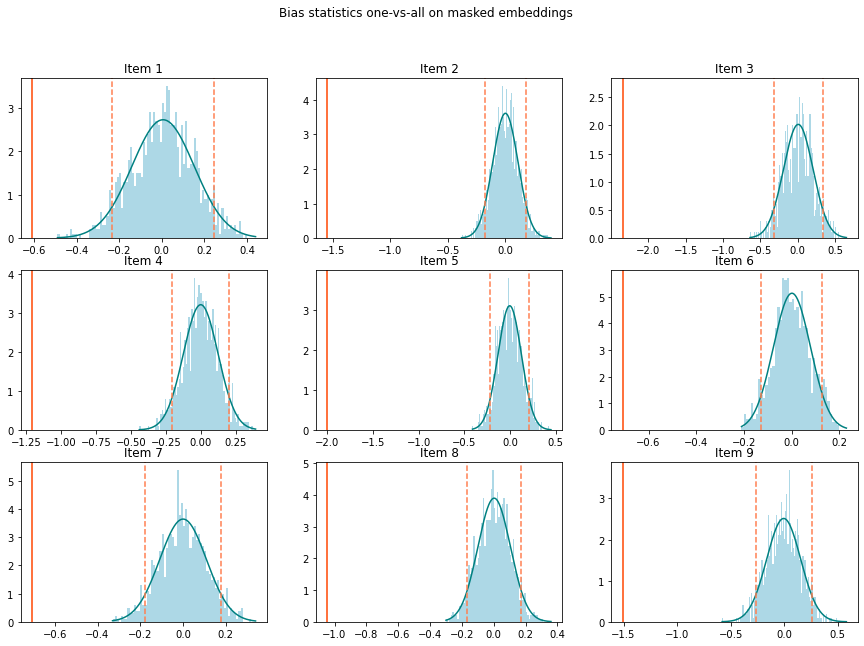

In [13]:
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

for i, item in zip(range(3), range(1, 4)):
    plot_WEAT_bias(axs[0, i], item)

for i, item in zip(range(3), range(4, 7)):
    plot_WEAT_bias(axs[1, i], item)

for i, item in zip(range(3), range(7, 10)):
    plot_WEAT_bias(axs[2, i], item)

fig.suptitle(f'Bias statistics one-vs-all on {MODE} embeddings')
plt.savefig(BIAS + f'bias_plot_{MODE}.pdf')